### Install libraries
<font color='red'>**Make sure to restart the Colab runtime after installation**</font>

Colab Menu -> Runtime -> Restart runtime

In [7]:
!pip install open_clip_torch transformers matplotlib

  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)


## Load BiomedCLIP model

In [2]:
from collections import OrderedDict

import timm
from torch import nn
from models.pointnet2.pointnet2 import Pointnet2_Ssg
from data.dataset_3d import  *

from torch.nn.parameter import Parameter
from easydict import EasyDict

import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'cls.predictions.decoder.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
from pprint import pprint

pprint( preprocess_train )

pprint( preprocess_val )

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    <function _convert_to_rgb at 0x7f64da8a1a70>
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f64da8a1a70>
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)


# Download sample images

In [9]:
from huggingface_hub import snapshot_download
snapshot_download("microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224", local_dir="biomed-clip-share")

Fetching 20 files: 100%|██████████| 20/20 [00:00<00:00, 49.98it/s]


'/home/shezhan/sheng/repos/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/biomed-clip-share'

In [10]:
!ls biomed-clip-share

LICENSE.md		   example_data			tokenizer.json
README.md		   open_clip_config.json	tokenizer_config.json
biomed-vlp-eval.svg	   open_clip_pytorch_model.bin	vocab.txt
biomed_clip_example.ipynb  special_tokens_map.json


### Example: Zero-shot classifications

In [3]:
import glob
from collections import OrderedDict

import torch
from PIL import Image
import open_clip

dataset_path = 'biomed-clip-share/example_data/biomed_image_classification_example_data'
template = 'this is a photo of '
labels = [
    'adenocarcinoma histopathology',
    'brain MRI',
    'covid line chart',
    'squamous cell carcinoma histopathology',
    'immunohistochemistry histopathology',
    'bone X-ray',
    'chest X-ray',
    'pie chart',
    'hematoxylin and eosin histopathology'
]

test_imgs = glob.glob(dataset_path + '/*')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

context_length = 256

images = torch.stack([preprocess_val(Image.open(img)) for img in test_imgs]).to(device)
texts = tokenizer([template + l for l in labels], context_length=context_length).to(device) # check text shape, cx_len
# texts = tokenizer([template + l for l in labels]).to(device)

with torch.no_grad():
    image_features, text_features, logit_scale = model(images, texts) # check input pipeline

    logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
    sorted_indices = torch.argsort(logits, dim=-1, descending=True)

    logits = logits.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()

top_k = -1

for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]

    top_k = len(labels) if top_k == -1 else top_k
    print(img.split('/')[-1] + ':')
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        print(f'{labels[jth_index]}: {logits[i][jth_index]}')
    print('\n')

bone_X-ray.jpg:
bone X-ray: 0.906035840511322
hematoxylin and eosin histopathology: 0.07079168409109116
brain MRI: 0.013391809538006783
chest X-ray: 0.00816812552511692
immunohistochemistry histopathology: 0.0015975728165358305
squamous cell carcinoma histopathology: 1.3656231203640345e-05
covid line chart: 1.0852020295715192e-06
adenocarcinoma histopathology: 2.3375413604753703e-07
pie chart: 9.263764155775789e-08


chest_X-ray.jpg:
chest X-ray: 0.9998345375061035
hematoxylin and eosin histopathology: 0.0001206661036121659
bone X-ray: 4.127575448364951e-05
immunohistochemistry histopathology: 1.054361973729101e-06
adenocarcinoma histopathology: 9.66889501796686e-07
covid line chart: 9.534511491438025e-07
brain MRI: 3.248411815093277e-07
squamous cell carcinoma histopathology: 2.538808416829852e-07
pie chart: 3.7009575404312045e-09


squamous_cell_carcinoma_histopathology.jpeg:
squamous cell carcinoma histopathology: 0.9573756456375122
adenocarcinoma histopathology: 0.04225408658385277

In [6]:
print([template + l for l in labels])
print(texts.shape)

['this is a photo of adenocarcinoma histopathology', 'this is a photo of brain MRI', 'this is a photo of covid line chart', 'this is a photo of squamous cell carcinoma histopathology', 'this is a photo of immunohistochemistry histopathology', 'this is a photo of bone X-ray', 'this is a photo of chest X-ray', 'this is a photo of pie chart', 'this is a photo of hematoxylin and eosin histopathology']
torch.Size([9, 256])


<h2>Expected outputs</h2>
<details>
<pre>
adenocarcinoma_histopathology.jpg:
adenocarcinoma histopathology: 0.7818863987922668
hematoxylin and eosin histopathology: 0.15517690777778625
immunohistochemistry histopathology: 0.06149514392018318
squamous cell carcinoma histopathology: 0.0014182085869833827
chest X-ray: 2.017213228100445e-05
brain MRI: 1.2181524198240368e-06
pie chart: 7.932688959044754e-07
bone X-ray: 7.436410101036017e-07
covid line chart: 4.482610052036762e-07


covid_line_chart.png:
covid line chart: 0.9493210315704346
adenocarcinoma histopathology: 0.01898195780813694
squamous cell carcinoma histopathology: 0.0175501499325037
immunohistochemistry histopathology: 0.006791787222027779
hematoxylin and eosin histopathology: 0.003417333820834756
brain MRI: 0.002629919210448861
chest X-ray: 0.0010041205678135157
bone X-ray: 0.00024685842799954116
pie chart: 5.6812208640621975e-05


bone_X-ray.jpg:
bone X-ray: 0.9037961959838867
hematoxylin and eosin histopathology: 0.07279316335916519
brain MRI: 0.013534954749047756
chest X-ray: 0.00821212213486433
immunohistochemistry histopathology: 0.001647887285798788
squamous cell carcinoma histopathology: 1.418814281350933e-05
covid line chart: 1.1351590956110158e-06
adenocarcinoma histopathology: 2.3802124360372545e-07
pie chart: 9.433303205241828e-08


pie_chart.png:
pie chart: 0.999992847442627
covid line chart: 6.056906840967713e-06
brain MRI: 6.212158041307703e-07
bone X-ray: 1.870277799298492e-07
chest X-ray: 1.4315827456812258e-07
immunohistochemistry histopathology: 7.397970591682679e-08
hematoxylin and eosin histopathology: 1.3329795045535775e-08
adenocarcinoma histopathology: 7.695367898463701e-09
squamous cell carcinoma histopathology: 4.512833662317917e-09


H_and_E_histopathology.jpg:
hematoxylin and eosin histopathology: 0.7953251600265503
immunohistochemistry histopathology: 0.19779996573925018
chest X-ray: 0.005973907187581062
bone X-ray: 0.0008049230673350394
adenocarcinoma histopathology: 9.133991261478513e-05
squamous cell carcinoma histopathology: 3.6423973597266013e-06
brain MRI: 6.688684948130685e-07
pie chart: 4.278819574210502e-07
covid line chart: 3.051619401617245e-08


brain_MRI.jpg:
brain MRI: 0.9565795660018921
hematoxylin and eosin histopathology: 0.041418157517910004
immunohistochemistry histopathology: 0.0019450499676167965
pie chart: 2.7151252652402036e-05
squamous cell carcinoma histopathology: 1.0223812751064543e-05
bone X-ray: 8.662499567435589e-06
chest X-ray: 7.96773747424595e-06
adenocarcinoma histopathology: 2.7692055937222904e-06
covid line chart: 3.420084908611898e-07


chest_X-ray.jpg:
chest X-ray: 0.9998347759246826
hematoxylin and eosin histopathology: 0.0001205605294671841
bone X-ray: 4.112880560569465e-05
immunohistochemistry histopathology: 1.0486423889233265e-06
adenocarcinoma histopathology: 9.66637117016944e-07
covid line chart: 9.508977996119938e-07
brain MRI: 3.232386518448038e-07
squamous cell carcinoma histopathology: 2.53368597213921e-07
pie chart: 3.6984038054299617e-09


squamous_cell_carcinoma_histopathology.jpeg:
squamous cell carcinoma histopathology: 0.9469489455223083
adenocarcinoma histopathology: 0.05259034037590027
hematoxylin and eosin histopathology: 0.0003988408425357193
immunohistochemistry histopathology: 6.187965482240543e-05
chest X-ray: 1.4099594380923008e-08
pie chart: 3.522500624519864e-10
bone X-ray: 2.9633814846441453e-10
brain MRI: 1.2720452469139332e-10
covid line chart: 1.8425603924565603e-12


IHC_histopathology.jpg:
immunohistochemistry histopathology: 0.9465934634208679
hematoxylin and eosin histopathology: 0.03232448548078537
brain MRI: 0.020657211542129517
adenocarcinoma histopathology: 0.000304735847748816
bone X-ray: 4.5735167077509686e-05
squamous cell carcinoma histopathology: 3.150868360535242e-05
covid line chart: 2.0559578842949122e-05
chest X-ray: 1.2715442608168814e-05
pie chart: 9.55282575887395e-06
</pre>
</details>

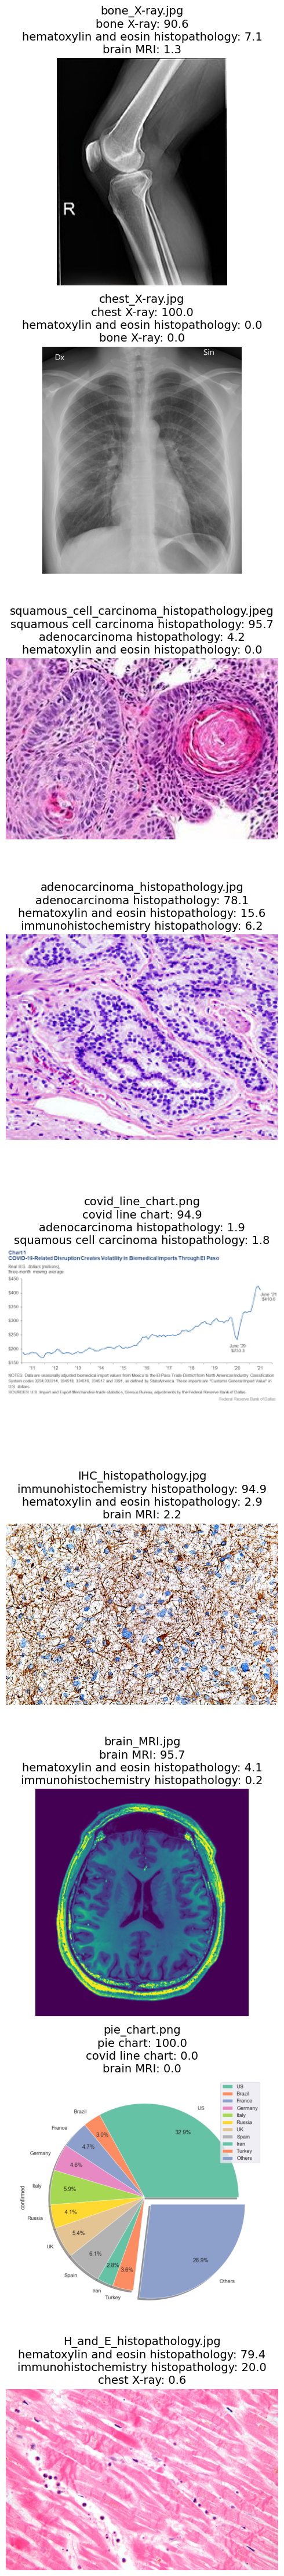

In [4]:
import matplotlib.pyplot as plt

def plot_images_with_metadata(images, metadata):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(5, 5 * num_images))

    for i, (img_path, metadata) in enumerate(zip(images, metadata)):
        img = Image.open(img_path)
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{metadata['filename']}\n{metadata['top_probs']}", fontsize=14)

    plt.tight_layout()
    plt.show()

metadata_list = []

top_k = 3
for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]
    img_name = img.split('/')[-1]

    top_probs = []
    top_k = len(labels) if top_k == -1 else top_k
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        top_probs.append(f"{labels[jth_index]}: {logits[i][jth_index] * 100:.1f}")

    metadata = {'filename': img_name, 'top_probs': '\n'.join(top_probs)}
    metadata_list.append(metadata)

plot_images_with_metadata(test_imgs, metadata_list)